We will first do some classical processing for classification of hyperspectral data. To that end, we use the Indian Pines Dataset.

In [1]:
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
# sns.axes_style('whitegrid');
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sn
def read_HSI():
  X = loadmat('Indian_pines_corrected.mat')['indian_pines_corrected']
  y = loadmat('Indian_pines_gt.mat')['indian_pines_gt']
  print(f"X shape: {X.shape}\ny shape: {y.shape}")
  return X, y

X, y = read_HSI()
orig_X = X
orig_Y = y

X shape: (145, 145, 200)
y shape: (145, 145)


As we can see, there is a single ground truth for every pixel in the image. So for a given image, we have to classify each of the pixel.

Let us now look at some random snips in the hyperspectral data

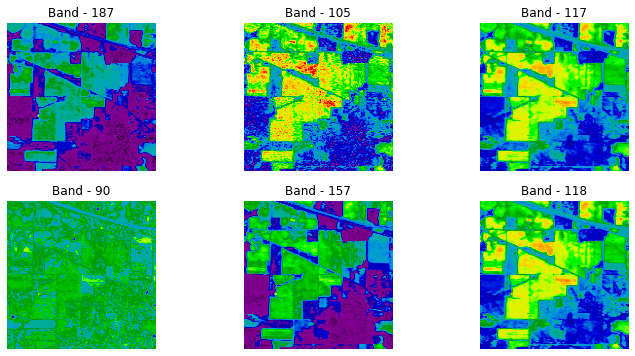

In [2]:
fig = plt.figure(figsize = (12, 6))

for i in range(1, 1+6):
    fig.add_subplot(2,3, i)
    q = np.random.randint(X.shape[2])
    plt.imshow(X[:,:,q], cmap='nipy_spectral')
    plt.axis('off')
    plt.title(f'Band - {q}')

Visualizing the ground truth labels

In [3]:
# Visualizing the Ground truth of the HSI
cls = px.imshow(y, color_continuous_scale='inferno',)
                
cls.update_layout(title = 'Gound Truth', coloraxis_showscale=True)
cls.update_xaxes(showticklabels=False)
cls.update_yaxes(showticklabels=False)
cls.show()
# py.plot(cls, filename = 'ground_truth', auto_open=True)

We can see that there is a spatio-spectral dependence which can be exploited by time series modelling which will be discussed later.

Some Preprocessing Steps

In [4]:
import pandas as pd
import numpy as np

def extract_pixels(X, y):
  q = X.reshape(-1, X.shape[2])
  df = pd.DataFrame(data = q)
  df = pd.concat([df, pd.DataFrame(data = y.ravel())], axis=1)
  df.columns= [f'band{i}' for i in range(1, 1+X.shape[2])]+['class']
  df.to_csv('Dataset.csv')
  return df
  
df = extract_pixels(X, y)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21025 entries, 0 to 21024
Columns: 201 entries, band1 to class
dtypes: uint16(200), uint8(1)
memory usage: 8.0 MB


In [6]:
df.iloc[:, :-1].describe()

band1         band2         band3         band4         band5  \
count  21025.000000  21025.000000  21025.000000  21025.000000  21025.000000   
mean    2957.363472   4091.321237   4277.502259   4169.956671   4516.678668   
std      354.918708    230.390005    257.827640    280.761254    346.035984   
min     2560.000000   2709.000000   3649.000000   2810.000000   3840.000000   
25%     2602.000000   3889.000000   4066.000000   3954.000000   4214.000000   
50%     2780.000000   4106.000000   4237.000000   4126.000000   4478.000000   
75%     3179.000000   4247.000000   4479.000000   4350.000000   4772.000000   
max     4536.000000   5744.000000   6361.000000   6362.000000   7153.000000   

              band6         band7         band8         band9        band10  \
count  21025.000000  21025.000000  21025.000000  21025.000000  21025.000000   
mean    4790.595149   4848.317574   4714.732509   4668.904828   4439.065541   
std      414.382138    469.247667    491.728349    533.232855    539.908195   
min     4056.000000   4004.000000   3865.000000   3775.000000   2792.000000   
25%     4425.000000   4421.000000   4263.000000   4173.000000   3940.000000   
50%     4754.000000   4808.000000   4666.000000   4632.000000   4404.000000   
75%     5093.000000   5198.000000   5100.000000   5084.000000   4860.000000   
max     7980.000000   8284.000000   8128.000000   8194.000000   7928.000000   

       ...       band191       band192       band193       band194  \
count  ...  21025.000000  21025.000000  21025.000000  21025.000000   
mean   ...   1079.310773   1061.927848   1060.210273   1063.276813   
std    ...     49.943791     38.843805     38.712195     41.920969   
min    ...    998.000000    998.000000    999.000000    999.000000   
25%    ...   1031.000000   1026.000000   1024.000000   1024.000000   
50%    ...   1068.000000   1053.000000   1052.000000   1054.000000   
75%    ...   1129.000000   1099.000000   1098.000000   1104.000000   
max    ...   1364.000000   1287.000000   1289.000000   1315.000000   

            band195       band196       band197       band198       band199  \
count  21025.000000  21025.000000  21025.000000  21025.000000  21025.000000   
mean    1050.048514   1040.201141   1043.370321   1030.194816   1015.571463   
std       34.242725     26.452672     29.794418     20.865106     11.386402   
min      993.000000    990.000000    992.000000    989.000000    986.000000   
25%     1019.000000   1016.000000   1016.000000   1012.000000   1006.000000   
50%     1043.000000   1033.000000   1035.000000   1026.000000   1014.000000   
75%     1083.000000   1066.000000   1072.000000   1050.000000   1024.000000   
max     1258.000000   1201.000000   1245.000000   1167.000000   1076.000000   

            band200  
count  21025.000000  
mean    1008.513579  
std        7.050921  
min      981.000000  
25%     1004.000000  
50%     1009.000000  
75%     1014.000000  
max     1036.000000  

[8 rows x 200 columns]

Let us now perform PCA on this data to reduce the dimensionality and hence the computational power required to train the models. We will see later in the project, how to use auto encoders for this purpose.

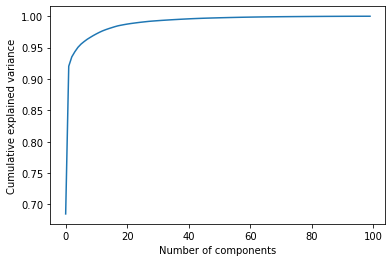

We can see that the variance flattebs for around 100 bands. Hence, it is justified to reduce the dimensionality to 80


In [7]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 100)

principalComponents = pca.fit_transform(df.iloc[:, :-1].values)

ev=pca.explained_variance_ratio_

plt.figure()
plt.plot(np.cumsum(ev))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()
print('We can see that the variance flattebs for around 100 bands. Hence, it is justified to reduce the dimensionality to 80')

Let us now display the bands after PCA. We show 8 bands here.

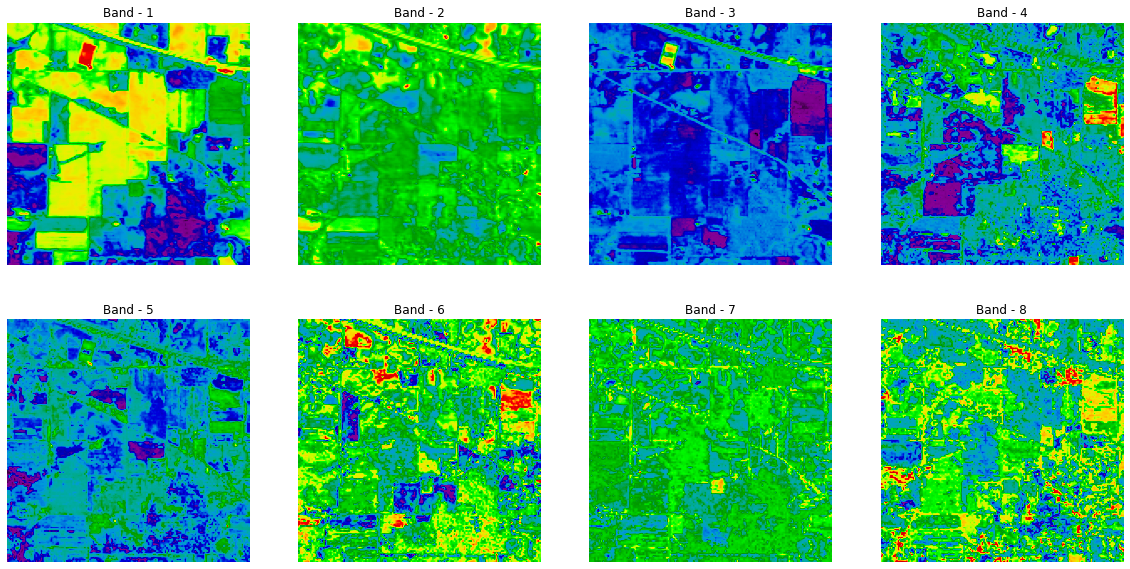

In [8]:
pca = PCA(n_components = 8)
dt = pca.fit_transform(df.iloc[:, :-1].values)
q = pd.concat([pd.DataFrame(data = dt), pd.DataFrame(data = y.ravel())], axis = 1)
q.columns = [f'PC-{i}' for i in range(1,9)]+['class']
fig = plt.figure(figsize = (20, 10))
for i in range(1, 1+8):
    fig.add_subplot(2,4, i)
    plt.imshow(q.loc[:, f'PC-{i}'].values.reshape(145,145), cmap='nipy_spectral')
    plt.axis('off')
    plt.title(f'Band - {i}')

Let us now look at some classical ML methods classifying the data after dimensionality reduction

In [10]:
pca = PCA(n_components = 100)

dt = pca.fit_transform(df.iloc[:, :-1].values)

q = pd.concat([pd.DataFrame(data = dt), pd.DataFrame(data = y.ravel())], axis = 1)

q.columns = [f'PC-{i}' for i in range(1,101)]+['class']

Let's look at Decision Trees

(10249, 100)
                              precision    recall  f1-score   support

                     Alfalfa       0.78      0.78      0.78         9
                 Corn-notill       0.66      0.64      0.65       286
                Corn-mintill       0.59      0.59      0.59       166
                        Corn       0.54      0.47      0.50        47
               Grass-pasture       0.81      0.79      0.80        97
                 Grass-trees       0.90      0.89      0.90       146
         Grass-pasture-mowed       0.20      0.20      0.20         5
               Hay-windrowed       0.97      0.94      0.95        96
                        Oats       0.00      0.00      0.00         4
              Soybean-notill       0.68      0.62      0.65       194
             Soybean-mintill       0.69      0.74      0.71       491
               Soybean-clean       0.56      0.59      0.57       119
                       Wheat       0.89      0.98      0.93        41
      

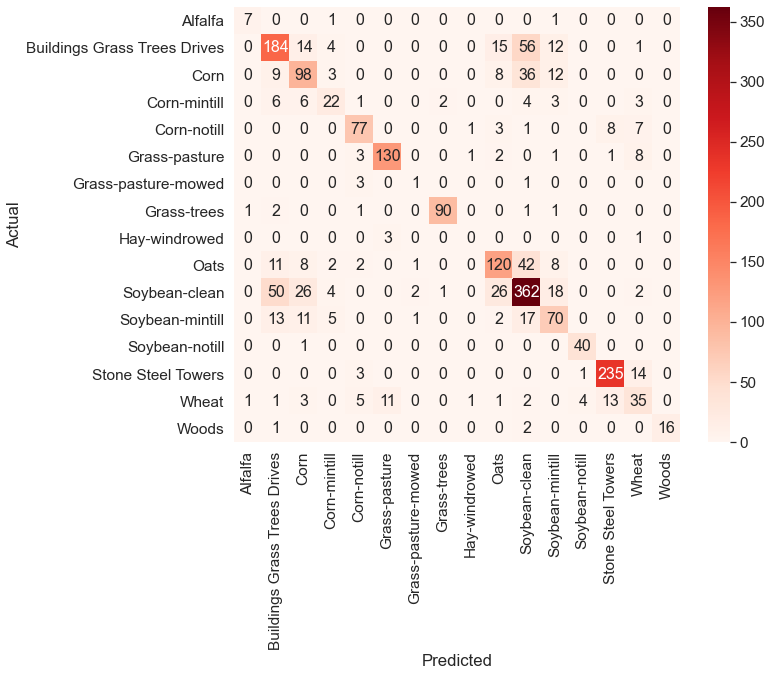

In [20]:
from IPython.display import Video
from matplotlib.ticker import FormatStrFormatter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression

from sklearn import metrics
x = q[q['class'] != 0]

X = x.iloc[:, :-1].values

y = x.loc[:, 'class'].values 

names = ['Alfalfa',	'Corn-notill', 'Corn-mintill',	'Corn',		'Grass-pasture','Grass-trees',
'Grass-pasture-mowed','Hay-windrowed','Oats','Soybean-notill','Soybean-mintill',
'Soybean-clean', 'Wheat',	'Woods',	'Buildings Grass Trees Drives',	'Stone Steel Towers']
print(X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=11, stratify=y)
from sklearn.tree import DecisionTreeClassifier 
dtree_model = DecisionTreeClassifier(max_depth = 10).fit(X_train, y_train) 
ypred = dtree_model.predict(X_test) 
data = confusion_matrix(y_test, ypred)
df_cm = pd.DataFrame(data, columns=np.unique(names), index = np.unique(names))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,8))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Reds", annot=True,annot_kws={"size": 16}, fmt='d')
plt.savefig('cmap.png', dpi=300)
print(classification_report(y_test, ypred, target_names = names))

Let's look at K-Nearest Neighbours Algorithm

                              precision    recall  f1-score   support

                     Alfalfa       1.00      0.67      0.80         9
                 Corn-notill       0.62      0.64      0.63       286
                Corn-mintill       0.71      0.63      0.67       166
                        Corn       0.53      0.38      0.44        47
               Grass-pasture       0.87      0.93      0.90        97
                 Grass-trees       0.84      0.99      0.91       146
         Grass-pasture-mowed       1.00      0.80      0.89         5
               Hay-windrowed       0.95      1.00      0.97        96
                        Oats       0.20      0.25      0.22         4
              Soybean-notill       0.67      0.78      0.72       194
             Soybean-mintill       0.76      0.81      0.79       491
               Soybean-clean       0.74      0.42      0.53       119
                       Wheat       0.89      0.98      0.93        41
                   

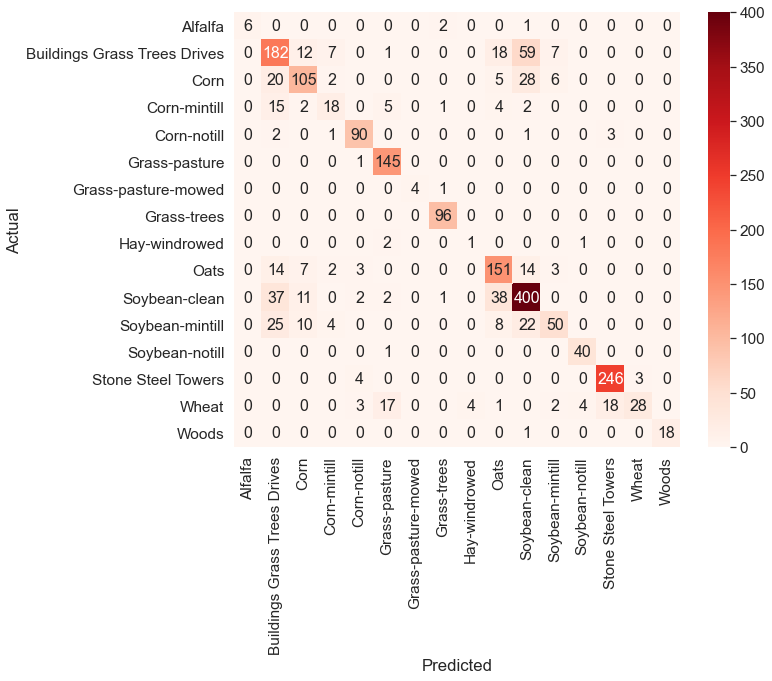

In [12]:
x = q[q['class'] != 0]

X = x.iloc[:, :-1].values

y = x.loc[:, 'class'].values 

names = ['Alfalfa',	'Corn-notill', 'Corn-mintill',	'Corn',		'Grass-pasture','Grass-trees',
'Grass-pasture-mowed','Hay-windrowed','Oats','Soybean-notill','Soybean-mintill',
'Soybean-clean', 'Wheat',	'Woods',	'Buildings Grass Trees Drives',	'Stone Steel Towers']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=11, stratify=y)
from sklearn.neighbors import KNeighborsClassifier 
knn = KNeighborsClassifier(n_neighbors = 10).fit(X_train, y_train) 
ypred=knn.predict(X_test)
data = confusion_matrix(y_test, ypred)
df_cm = pd.DataFrame(data, columns=np.unique(names), index = np.unique(names))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,8))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Reds", annot=True,annot_kws={"size": 16}, fmt='d')
plt.savefig('cmap.png', dpi=300)
print(classification_report(y_test, ypred, target_names = names))

Naive Bayes Classification 

                              precision    recall  f1-score   support

                     Alfalfa       1.00      0.67      0.80         9
                 Corn-notill       0.62      0.64      0.63       286
                Corn-mintill       0.71      0.63      0.67       166
                        Corn       0.53      0.38      0.44        47
               Grass-pasture       0.87      0.93      0.90        97
                 Grass-trees       0.84      0.99      0.91       146
         Grass-pasture-mowed       1.00      0.80      0.89         5
               Hay-windrowed       0.95      1.00      0.97        96
                        Oats       0.20      0.25      0.22         4
              Soybean-notill       0.67      0.78      0.72       194
             Soybean-mintill       0.76      0.81      0.79       491
               Soybean-clean       0.74      0.42      0.53       119
                       Wheat       0.89      0.98      0.93        41
                   

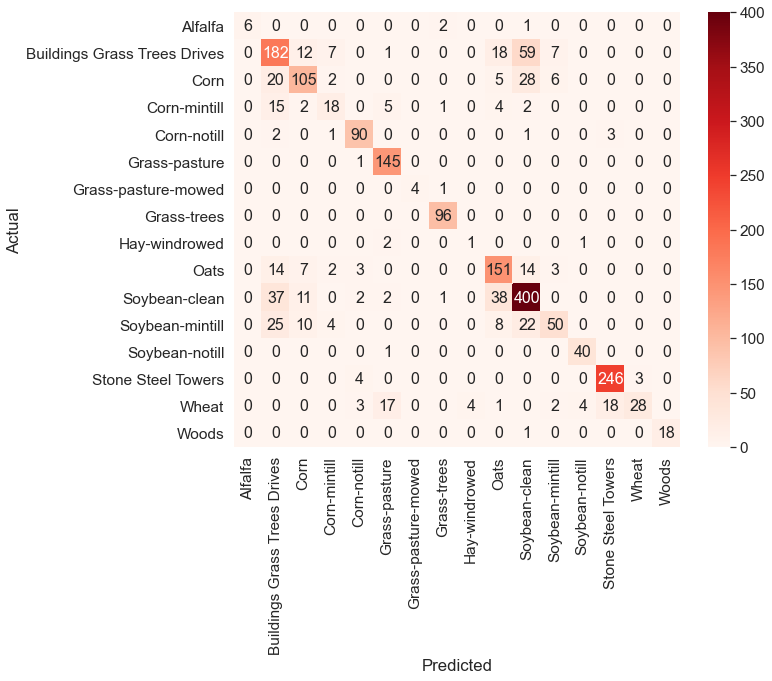

In [13]:
from sklearn.naive_bayes import GaussianNB 
gnb = GaussianNB().fit(X_train, y_train) 
ypred = gnb.predict(X_test) 
ypred=knn.predict(X_test)
data = confusion_matrix(y_test, ypred)
df_cm = pd.DataFrame(data, columns=np.unique(names), index = np.unique(names))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,8))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Reds", annot=True,annot_kws={"size": 16}, fmt='d')
plt.savefig('cmap.png', dpi=300)
print(classification_report(y_test, ypred, target_names = names))

SVM with linear kernel

In [13]:
# svm =  LinearSVC(max_iter=2000,C=100,multi_class='ovr')
# svm.fit(X_train, y_train)
# ypred = svm.predict(X_test)
# data = confusion_matrix(y_test, ypred)
# df_cm = pd.DataFrame(data, columns=np.unique(names), index = np.unique(names))
# df_cm.index.name = 'Actual'
# df_cm.columns.name = 'Predicted'
# plt.figure(figsize = (10,8))
# sn.set(font_scale=1.4)#for label size
# sn.heatmap(df_cm, cmap="Reds", annot=True,annot_kws={"size": 16}, fmt='d')
# plt.savefig('cmap.png', dpi=300)
# print(classification_report(y_test, ypred, target_names = names))

Let's now look at SVM with RBF Kernel

                              precision    recall  f1-score   support

                     Alfalfa       1.00      0.89      0.94         9
                 Corn-notill       0.92      0.89      0.90       286
                Corn-mintill       0.91      0.85      0.88       166
                        Corn       0.81      0.81      0.81        47
               Grass-pasture       0.94      0.96      0.95        97
                 Grass-trees       0.99      0.97      0.98       146
         Grass-pasture-mowed       1.00      0.80      0.89         5
               Hay-windrowed       0.99      1.00      0.99        96
                        Oats       0.67      0.50      0.57         4
              Soybean-notill       0.91      0.86      0.88       194
             Soybean-mintill       0.87      0.94      0.90       491
               Soybean-clean       0.91      0.92      0.92       119
                       Wheat       0.95      1.00      0.98        41
                   

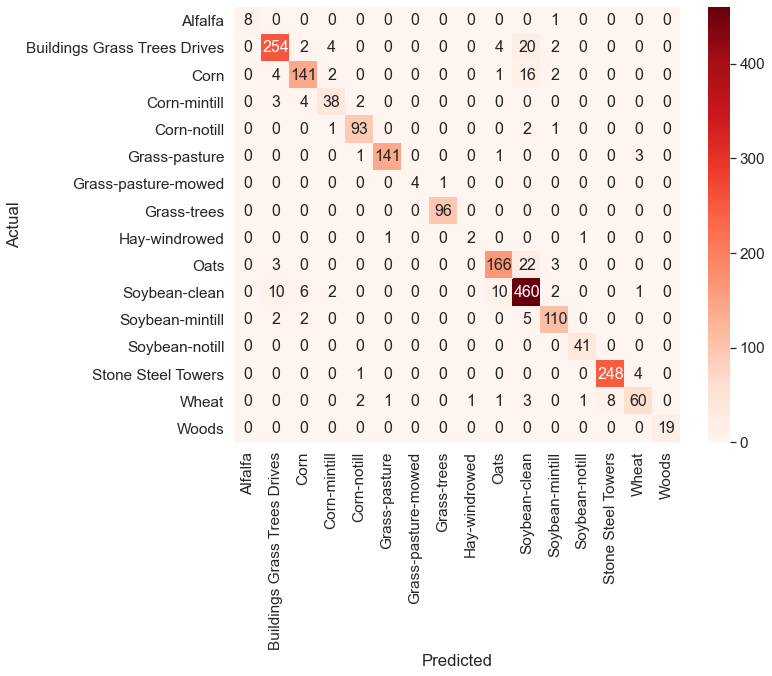

In [14]:
svm =  SVC(C=100)
svm.fit(X_train, y_train)
ypred = svm.predict(X_test)
data = confusion_matrix(y_test, ypred)
df_cm = pd.DataFrame(data, columns=np.unique(names), index = np.unique(names))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,8))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Reds", annot=True,annot_kws={"size": 16}, fmt='d')
plt.savefig('cmap.png', dpi=300)
print(classification_report(y_test, ypred, target_names = names))

SVM with polynomial kernel

                              precision    recall  f1-score   support

                     Alfalfa       0.89      0.89      0.89         9
                 Corn-notill       0.86      0.89      0.88       286
                Corn-mintill       0.85      0.84      0.85       166
                        Corn       0.83      0.72      0.77        47
               Grass-pasture       0.92      0.96      0.94        97
                 Grass-trees       0.94      0.97      0.95       146
         Grass-pasture-mowed       1.00      0.80      0.89         5
               Hay-windrowed       0.98      0.99      0.98        96
                        Oats       0.67      0.50      0.57         4
              Soybean-notill       0.90      0.82      0.86       194
             Soybean-mintill       0.87      0.89      0.88       491
               Soybean-clean       0.87      0.93      0.90       119
                       Wheat       0.95      1.00      0.98        41
                   

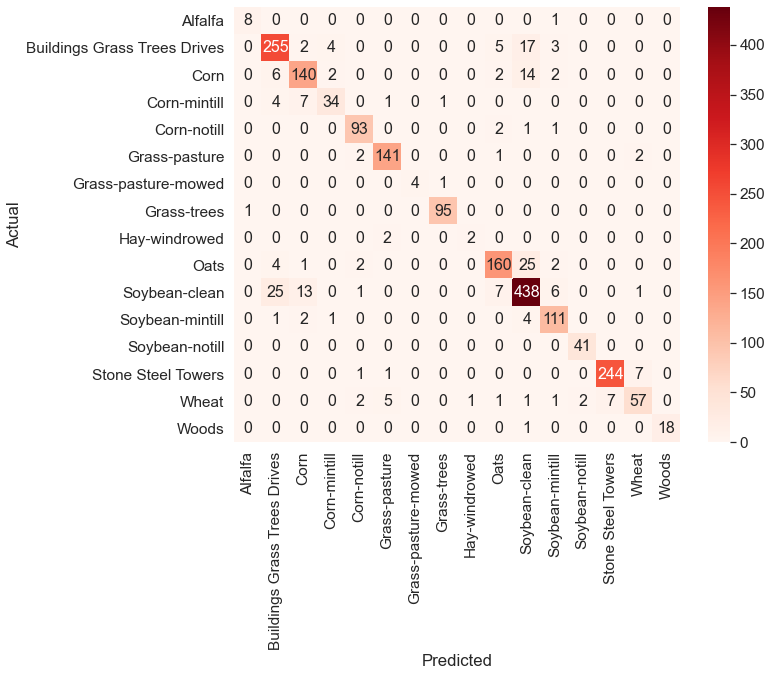

In [15]:
svm =  SVC(kernel='poly',C=1000,degree=3)
svm.fit(X_train, y_train)
ypred = svm.predict(X_test)
data = confusion_matrix(y_test, ypred)
df_cm = pd.DataFrame(data, columns=np.unique(names), index = np.unique(names))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,8))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Reds", annot=True,annot_kws={"size": 16}, fmt='d')
plt.savefig('cmap.png', dpi=300)
print(classification_report(y_test, ypred, target_names = names))

Let's now look at how neural networks perform with this data. If we have better results then it points towards deep learning 

In [16]:
from sklearn.neural_network import MLPClassifier
model =  MLPClassifier(hidden_layer_sizes=(1000,400), max_iter=2000, alpha=1e-4,
                    solver='adam')
model.fit(X_train,y_train)

MLPClassifier(hidden_layer_sizes=(1000, 400), max_iter=2000)

                              precision    recall  f1-score   support

                     Alfalfa       1.00      0.67      0.80         9
                 Corn-notill       0.90      0.79      0.84       286
                Corn-mintill       0.94      0.71      0.81       166
                        Corn       0.75      0.83      0.79        47
               Grass-pasture       0.62      0.96      0.75        97
                 Grass-trees       0.98      0.94      0.96       146
         Grass-pasture-mowed       1.00      0.80      0.89         5
               Hay-windrowed       0.97      1.00      0.98        96
                        Oats       0.80      1.00      0.89         4
              Soybean-notill       0.86      0.87      0.86       194
             Soybean-mintill       0.83      0.94      0.88       491
               Soybean-clean       0.87      0.90      0.88       119
                       Wheat       0.95      1.00      0.98        41
                   

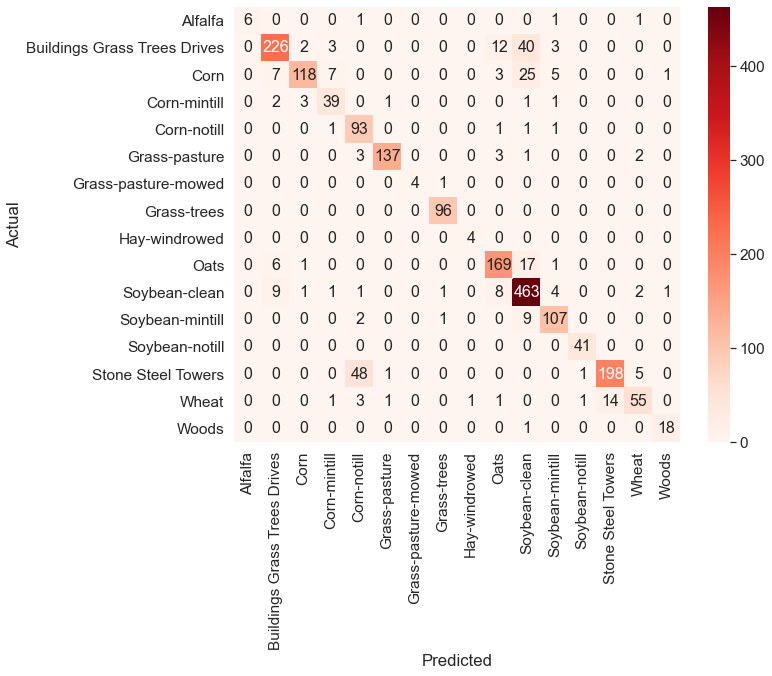

In [17]:
ypred = model.predict(X_test)
data = confusion_matrix(y_test, ypred)
df_cm = pd.DataFrame(data, columns=np.unique(names), index = np.unique(names))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,8))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Reds", annot=True,annot_kws={"size": 16}, fmt='d')
plt.savefig('cmap.png', dpi=300)
print(classification_report(y_test, ypred, target_names = names))